<a href="https://colab.research.google.com/github/lamtranBKHN/MAIT_2020_LabMemberDectector/blob/origin/MAIT_2020_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

In [ ]:
data_dir = '/content/drive/Shareddrives/Lâm_Trần/MAIT2020/Lab_Face_data_Exacted/scaleFactor=1.1_minNeighbors=6/'
print(os.listdir(data_dir))

['Bui_Quang_Duy', 'Thanh_Quang', 'Nguyen_Ba_Hoang', 'Nguyen_Thi_Huong', 'Tran_Minh_Thuyet', 'Tran_Thi_Thanh_Nhan', 'HDTuan_192259 (1)', 'PGPhong_181691', 'Phuong_Anh', 'Toan', 'CQDat_181383', 'DADung_181421', 'DLTMy_200426', 'DPDuong_181432', 'HDTuan_192259', 'KTAnh_176917', 'LDTAnh_181320', 'LTHien_173846', 'NBHoang_181486', 'NDHuy_161823', 'NDQuan_192034', 'NDToan_174273', 'NNHoang_181492', 'NQAnh_181325', 'NQThai_192002', 'NTCong_179626', 'NTHai_173821', 'NTHLy_181637', 'NTTung_181828', 'NVLinh_181579 (1)', 'NVMinh_174064', 'TDPhu_181692 (1)', 'THGiang_192200', 'THHoang_181888', 'TQMinh_181659', 'TVSon_181920', 'TVThai_181749', 'VCThinh_174239', 'NVLinh_181579', 'TDPhu_181692', 'TVThai_181759', 'VVHung_192210']


In [ ]:
num_skipped = 0

for fname in os.listdir(data_dir):
  print("Processing " + fname + " ... ")
  personal_img_path = os.path.join(data_dir, fname) 
  for fname in os.listdir(personal_img_path):
    fpath = os.path.join(personal_img_path, fname)
    try:
        fobj = open(fpath, "rb")
        is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
    finally:
        fobj.close()

    if not is_jfif:
        num_skipped += 1
        # Delete corrupted image
        os.remove(fpath)

print("Deleted %d images" % num_skipped)

Processing Bui_Quang_Duy ... 
Processing Thanh_Quang ... 
Processing Nguyen_Ba_Hoang ... 
Processing Nguyen_Thi_Huong ... 
Processing Tran_Minh_Thuyet ... 
Processing Tran_Thi_Thanh_Nhan ... 
Processing HDTuan_192259 (1) ... 
Processing PGPhong_181691 ... 
Processing Phuong_Anh ... 
Processing Toan ... 
Processing CQDat_181383 ... 
Processing DADung_181421 ... 
Processing DLTMy_200426 ... 
Processing DPDuong_181432 ... 
Processing HDTuan_192259 ... 
Processing KTAnh_176917 ... 
Processing LDTAnh_181320 ... 
Processing LTHien_173846 ... 
Processing NBHoang_181486 ... 
Processing NDHuy_161823 ... 
Processing NDQuan_192034 ... 
Processing NDToan_174273 ... 
Processing NNHoang_181492 ... 
Processing NQAnh_181325 ... 
Processing NQThai_192002 ... 
Processing NTCong_179626 ... 
Processing NTHai_173821 ... 
Processing NTHLy_181637 ... 
Processing NTTung_181828 ... 
Processing NVLinh_181579 (1) ... 
Processing NVMinh_174064 ... 
Processing TDPhu_181692 (1) ... 
Processing THGiang_192200 ... 
P

In [ ]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 233 files belonging to 42 classes.
Using 187 files for training.
Found 233 files belonging to 42 classes.
Using 46 files for validation.


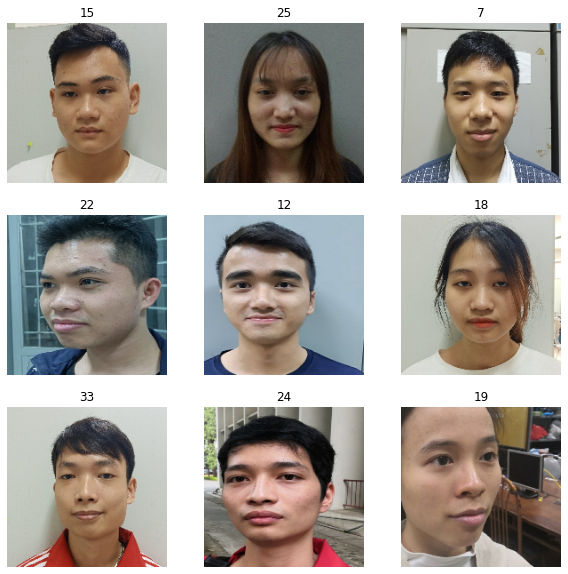

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

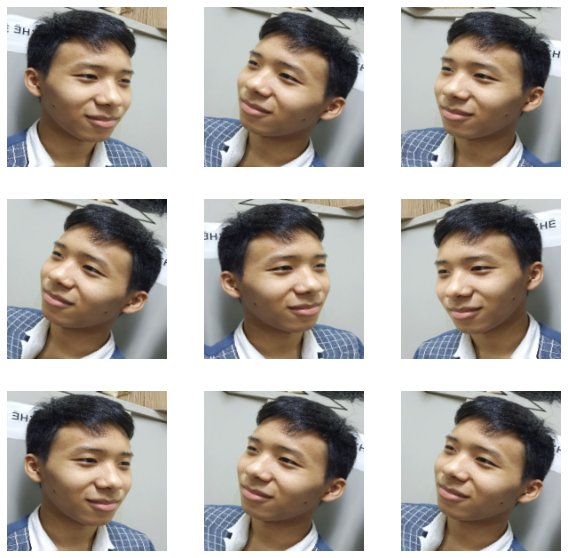

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

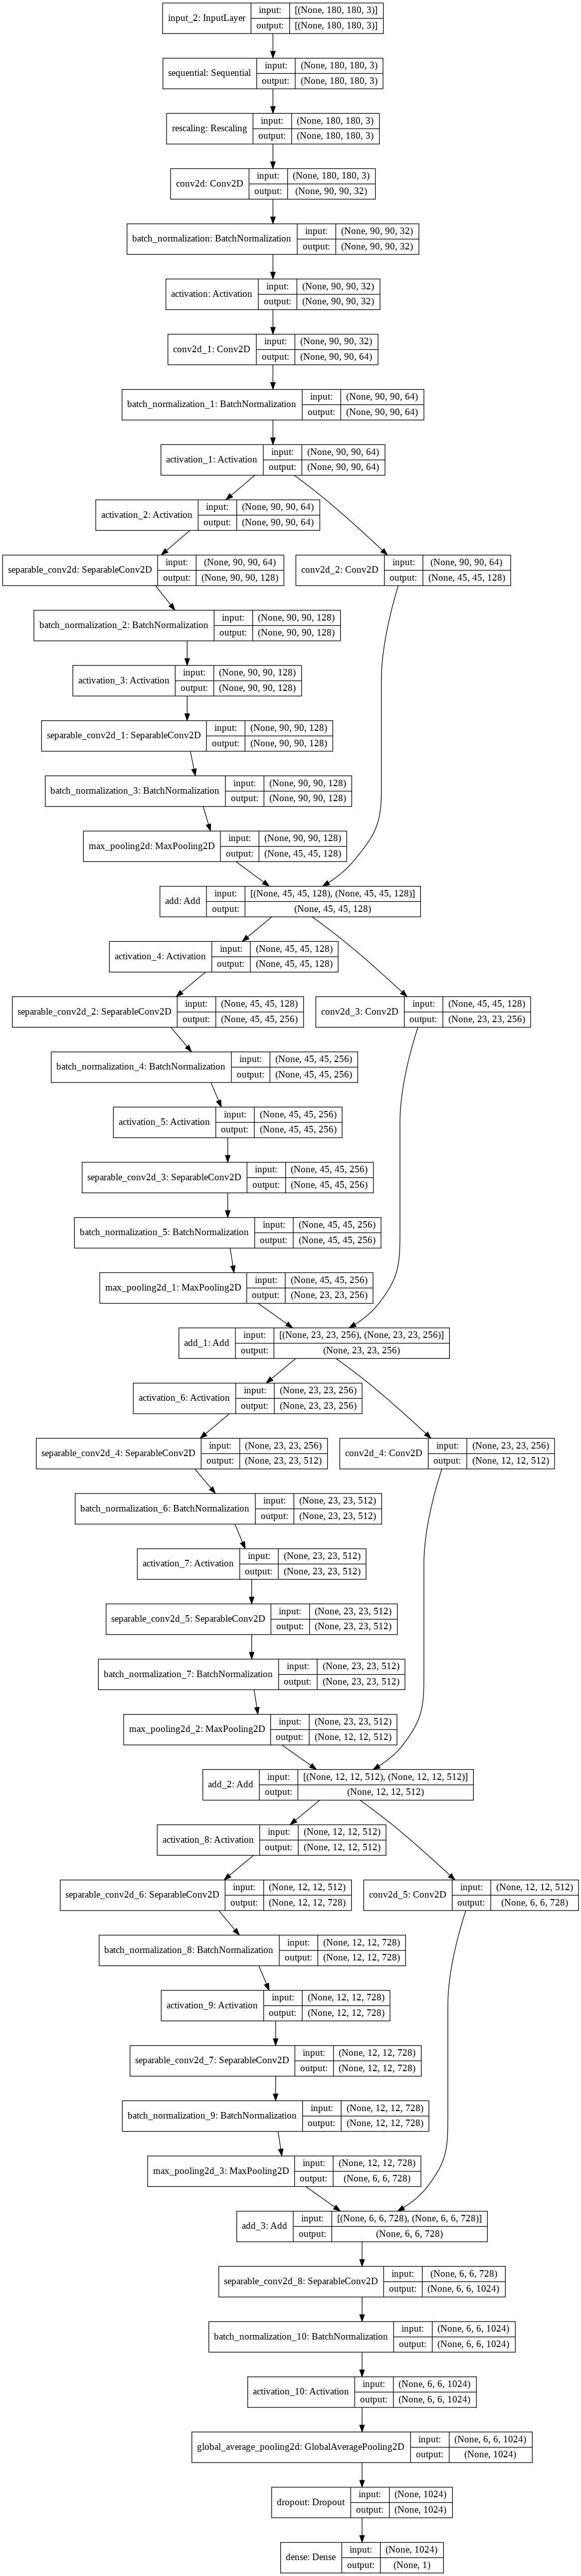

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
6/6 [==============================] - 13s 600ms/step - loss: -20.0728 - accuracy: 0.0015 - val_loss: -1.3179 - val_accuracy: 0.0217
Epoch 2/50
6/6 [==============================] - 2s 276ms/step - loss: -98.4074 - accuracy: 0.0242 - val_loss: -2.7305 - val_accuracy: 0.0217
Epoch 3/50
6/6 [==============================] - 2s 275ms/step - loss: -187.6342 - accuracy: 0.0300 - val_loss: -3.7828 - val_accuracy: 0.0217
Epoch 4/50
6/6 [==============================] - 2s 274ms/step - loss: -245.7485 - accuracy: 0.0214 - val_loss: -4.9203 - val_accuracy: 0.0217
Epoch 5/50
6/6 [==============================] - 2s 277ms/step - loss: -313.9008 - accuracy: 0.0383 - val_loss: -6.6572 - val_accuracy: 0.0217
Epoch 6/50
6/6 [==============================] - 2s 273ms/step - loss: -377.9278 - accuracy: 0.0182 - val_loss: -5.7385 - val_accuracy: 0.0217
Epoch 7/50
6/6 [==============================] - 2s 275ms/step - loss: -434.3021 - accuracy: 0.0249 - val_loss: -6.0511 - val_accuracy: 

KeyboardInterrupt: ignored